<a href="https://colab.research.google.com/github/KaushalDuggar/Digital-Twin/blob/main/Voltage_Run_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install tensorflow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import pandas as pd

# Read the Excel file
# Replace 'your_file.xlsx' with your actual Excel file name
df = pd.read_excel('/content/drive/MyDrive/Digital_Twin/corrected_data.xlsx')

# Get all column names
columns = df.columns.tolist()

# Separate voltage and current columns
voltage_columns = columns[::2]  # Every even indexed column (0, 2, 4, ...)
current_columns = columns[1::2]  # Every odd indexed column (1, 3, 5, ...)

# Create new dataframe with renamed columns
new_df = pd.DataFrame()

# Add voltage columns with renamed headers
for i, col in enumerate(voltage_columns):
    new_df[f'Voltage_{i+1}'] = df[col]



# Display first few rows of the new dataframe
print(new_df.head())

   Voltage_1  Voltage_2  Voltage_3  Voltage_4  Voltage_5  Voltage_6  \
0  -0.000054  -0.000061  -0.000061  -0.000072  -0.000095  -0.000095   
1  -0.000127  -0.000140  -0.000140  -0.000170  -0.000222  -0.000222   
2  -0.000200  -0.000218  -0.000218  -0.000268  -0.000347  -0.000347   
3  -0.000271  -0.000295  -0.000295  -0.000364  -0.000471  -0.000471   
4  -0.000342  -0.000372  -0.000372  -0.000459  -0.000594  -0.000594   

   Voltage_7  Voltage_8  Voltage_9  Voltage_10  ...  Voltage_15  Voltage_16  \
0  -0.000065  -0.000049  -0.000048   -0.000059  ...   -0.000093   -0.000097   
1  -0.000144  -0.000108  -0.000107   -0.000133  ...   -0.000211   -0.000220   
2  -0.000222  -0.000166  -0.000166   -0.000206  ...   -0.000328   -0.000341   
3  -0.000299  -0.000224  -0.000223   -0.000278  ...   -0.000443   -0.000462   
4  -0.000375  -0.000281  -0.000280   -0.000350  ...   -0.000558   -0.000581   

   Voltage_17  Voltage_18  Voltage_19  Voltage_20  Voltage_21  Voltage_22  \
0   -0.000090   -0.00

In [18]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def prepare_sequences(df, n_steps=100):
    """
    Prepare sequences for time series prediction

    Args:
        df: DataFrame with voltage columns
        n_steps: Number of time steps to use for prediction

    Returns:
        X: Input sequences with shape (samples, time_steps, features)
        series_ids: Series identifiers for each sequence
        y: Target values
    """
    X, series_ids, y = [], [], []
    voltage_cols = [col for col in df.columns if 'Voltage_' in col]

    for series_idx, col in enumerate(voltage_cols):
        series_data = df[col].values

        # Create sequences for this series
        for j in range(len(series_data) - n_steps):
            X.append(series_data[j:j+n_steps])
            series_ids.append(series_idx)
            y.append(series_data[j+n_steps])

    return np.array(X), np.array(series_ids), np.array(y)

# Parameters
n_steps = 100  # Number of time steps in each sequence
test_size = 0.2  # Percentage of data to use for testing

# Prepare sequences
X, series_ids, y = prepare_sequences(new_df, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM (samples, timesteps, features)

# Create train-test split - IMPORTANT: For time series, we shouldn't shuffle!
# Split by series to keep temporal order
unique_series = np.unique(series_ids)
train_series = unique_series[:int(len(unique_series)*(1-test_size))]
test_series = unique_series[int(len(unique_series)*(1-test_size)):]

train_mask = np.isin(series_ids, train_series)
test_mask = np.isin(series_ids, test_series)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
series_ids_train, series_ids_test = series_ids[train_mask], series_ids[test_mask]

# Scale data - scale each series individually
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# For training data
X_train_scaled = np.zeros_like(X_train)
y_train_scaled = np.zeros_like(y_train)

for series_id in train_series:
    mask = (series_ids_train == series_id)
    # Scale X
    X_train_scaled[mask] = scaler_X.fit_transform(X_train[mask].reshape(-1, 1)).reshape(X_train[mask].shape)
    # Scale y
    y_train_scaled[mask] = scaler_y.fit_transform(y_train[mask].reshape(-1, 1)).flatten()

# For test data (use the same scalers from training)
X_test_scaled = np.zeros_like(X_test)
y_test_scaled = np.zeros_like(y_test)

for series_id in test_series:
    mask = (series_ids_test == series_id)
    # Scale X
    X_test_scaled[mask] = scaler_X.transform(X_test[mask].reshape(-1, 1)).reshape(X_test[mask].shape)
    # Scale y
    y_test_scaled[mask] = scaler_y.transform(y_test[mask].reshape(-1, 1)).flatten()

print(f"Training shapes - X: {X_train_scaled.shape}, y: {y_train_scaled.shape}")
print(f"Test shapes - X: {X_test_scaled.shape}, y: {y_test_scaled.shape}")

Training shapes - X: (188100, 100, 1), y: (188100,)
Test shapes - X: (49500, 100, 1), y: (49500,)


Original Target Data Range: [0.256, 35.561]
Scaled Target Data Range: [-0.004, 1.171]


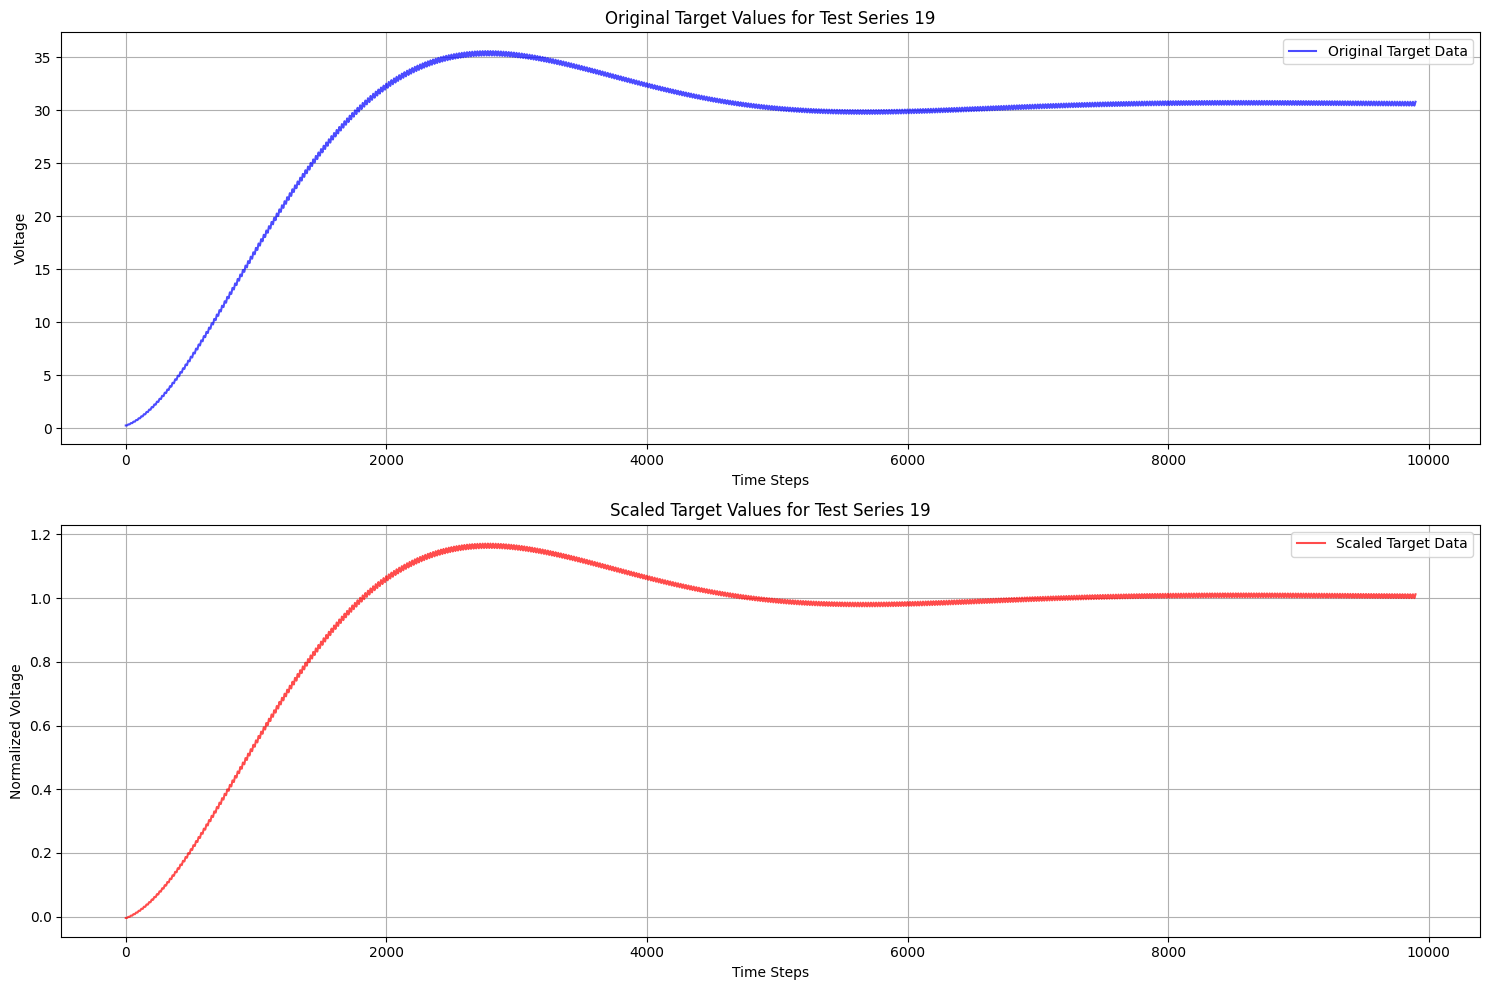

In [19]:
# Select a series ID from test_series
series_id = test_series[0]  # Taking first test series

# Get masks for this series
test_mask_series = (series_ids_test == series_id)

# Get original and scaled target values
original_y = y_test[test_mask_series]
scaled_y = y_test_scaled[test_mask_series]

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot original target data
ax1.plot(original_y, label='Original Target Data', color='blue', alpha=0.7)
ax1.set_title(f'Original Target Values for Test Series {series_id}')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Voltage')
ax1.grid(True)
ax1.legend()

# Plot scaled target data
ax2.plot(scaled_y, label='Scaled Target Data', color='red', alpha=0.7)
ax2.set_title(f'Scaled Target Values for Test Series {series_id}')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Normalized Voltage')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Print statistics
print(f"Original Target Data Range: [{original_y.min():.3f}, {original_y.max():.3f}]")
print(f"Scaled Target Data Range: [{scaled_y.min():.3f}, {scaled_y.max():.3f}]")

plt.show()

In [20]:
def build_pooled_model(n_steps, n_features, n_series):
    """
    Build a pooled neural network model with series identifiers

    Args:
        n_steps: Number of time steps in input sequences
        n_features: Number of features per time step
        n_series: Number of unique series (voltage columns)

    Returns:
        model: Compiled Keras model
    """
    # Input layers
    time_series_input = Input(shape=(n_steps, n_features), name='time_series_input')
    series_id_input = Input(shape=(1,), name='series_id_input')

    # Embed the series identifier
    embedding_dim = min(5, (n_series + 1) // 2)  # Rule of thumb for embedding dimension
    series_embedding = Embedding(input_dim=n_series, output_dim=embedding_dim)(series_id_input)
    series_embedding = Dense(embedding_dim)(series_embedding)
    series_embedding = Dropout(0.2)(series_embedding)

    # Process time series with LSTM
    lstm_out = LSTM(50, return_sequences=False)(time_series_input)
    lstm_out = Dropout(0.2)(lstm_out)

    # Flatten embedding before concatenation
    series_embedding_flat = Dense(embedding_dim, activation='relu')(series_embedding[:, 0, :])

    # Combine features
    concatenated = Concatenate()([lstm_out, series_embedding_flat])

    # Output layer
    output = Dense(1)(concatenated)

    # Define model
    model = Model(inputs=[time_series_input, series_id_input], outputs=output)

    # Compile model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout
n_steps = 100  # Number of time steps to use for prediction
n_features = 1  # Each sequence contains one feature (the voltage value)

Epoch 1/5
4703/4703 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0096 - mae: 0.0524

4703/4703 ━━━━━━━━━━━━━━━━━━━━ 227s 48ms/step - loss: 0.0096 - mae: 0.0524 - val_loss: 8.1604e-05 - val_mae: 0.0073
Epoch 2/5
4702/4703 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.2836e-04 - mae: 0.0118

4703/4703 ━━━━━━━━━━━━━━━━━━━━ 216s 46ms/step - loss: 3.2835e-04 - mae: 0.0118 - val_loss: 3.9204e-05 - val_mae: 0.0044
Epoch 3/5
4703/4703 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.7336e-04 - mae: 0.0104

4703/4703 ━━━━━━━━━━━━━━━━━━━━ 272s 48ms/step - loss: 2.7336e-04 - mae: 0.0104 - val_loss: 6.1377e-06 - val_mae: 0.0021
Epoch 4/5
4703/4703 ━━━━━━━━━━━━━━━━━━━━ 257s 47ms/step - loss: 2.6178e-04 - mae: 0.0100 - val_loss: 5.1776e-05 - val_mae: 0.0068
Epoch 5/5
4703/4703 ━━━━━━━━━━━━━━━━━━━━ 253s 45ms/step - loss: 2.5539e-04 - mae: 0.0097 - val_loss: 6.0700e-05 - val_mae: 0.0074

Test Loss (MSE): 0.0001
Test MAE: 0.0080
1547/1547 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step


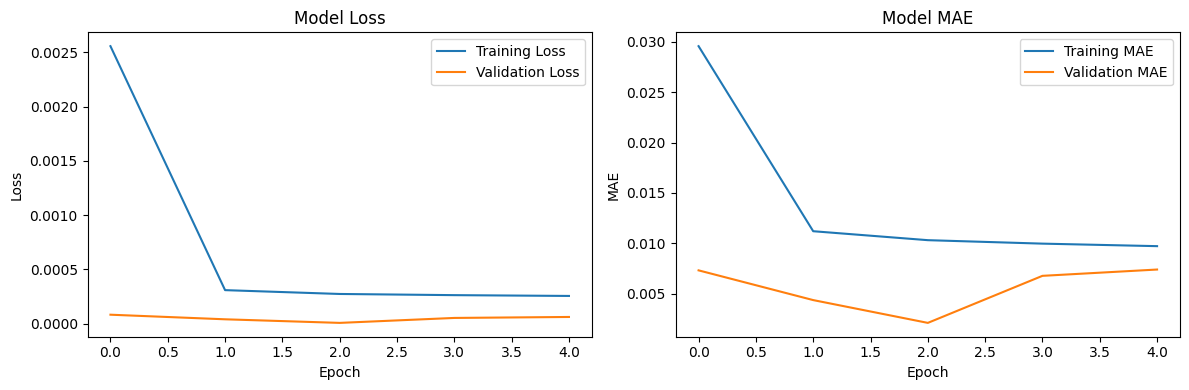

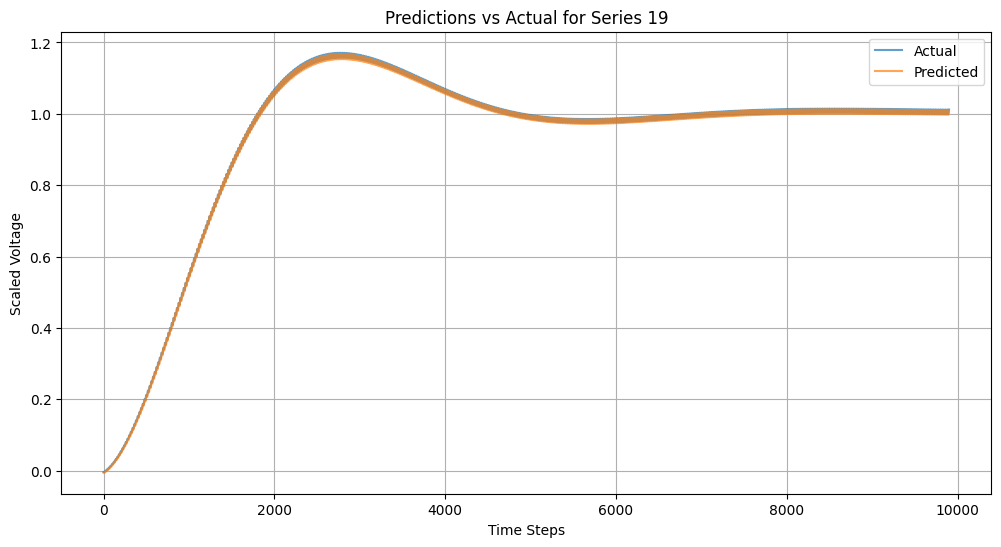

In [22]:
# Import required libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Get dimensions for model
n_steps = 100
n_features = 1
n_series = len(np.unique(series_ids))

# Build the model using the function you defined
model = build_pooled_model(n_steps, n_features, n_series)

# Prepare inputs for training
train_series_ids = series_ids_train.reshape(-1, 1)
test_series_ids = series_ids_test.reshape(-1, 1)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

# Train the model
history = model.fit(
    [X_train_scaled, train_series_ids],  # Input data
    y_train_scaled,                       # Target data
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Evaluate the model
test_loss = model.evaluate(
    [X_test_scaled, test_series_ids],
    y_test_scaled,
    verbose=0
)

print(f'\nTest Loss (MSE): {test_loss[0]:.4f}')
print(f'Test MAE: {test_loss[1]:.4f}')

# Make predictions
y_pred_scaled = model.predict([X_test_scaled, test_series_ids])

# Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Plot predictions vs actual for one series
test_series_id = test_series[0]
series_mask = (series_ids_test == test_series_id)

plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled[series_mask], label='Actual', alpha=0.7)
plt.plot(y_pred_scaled[series_mask], label='Predicted', alpha=0.7)
plt.title(f'Predictions vs Actual for Series {test_series_id}')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Voltage')
plt.legend()
plt.grid(True)
plt.show()

Scaled Values Range:
Actual: [-0.004, 1.171]
Predicted: [-0.006, 1.167]

Original Values Range:
Actual: [0.256, 35.561]
Predicted: [0.201, 35.437]


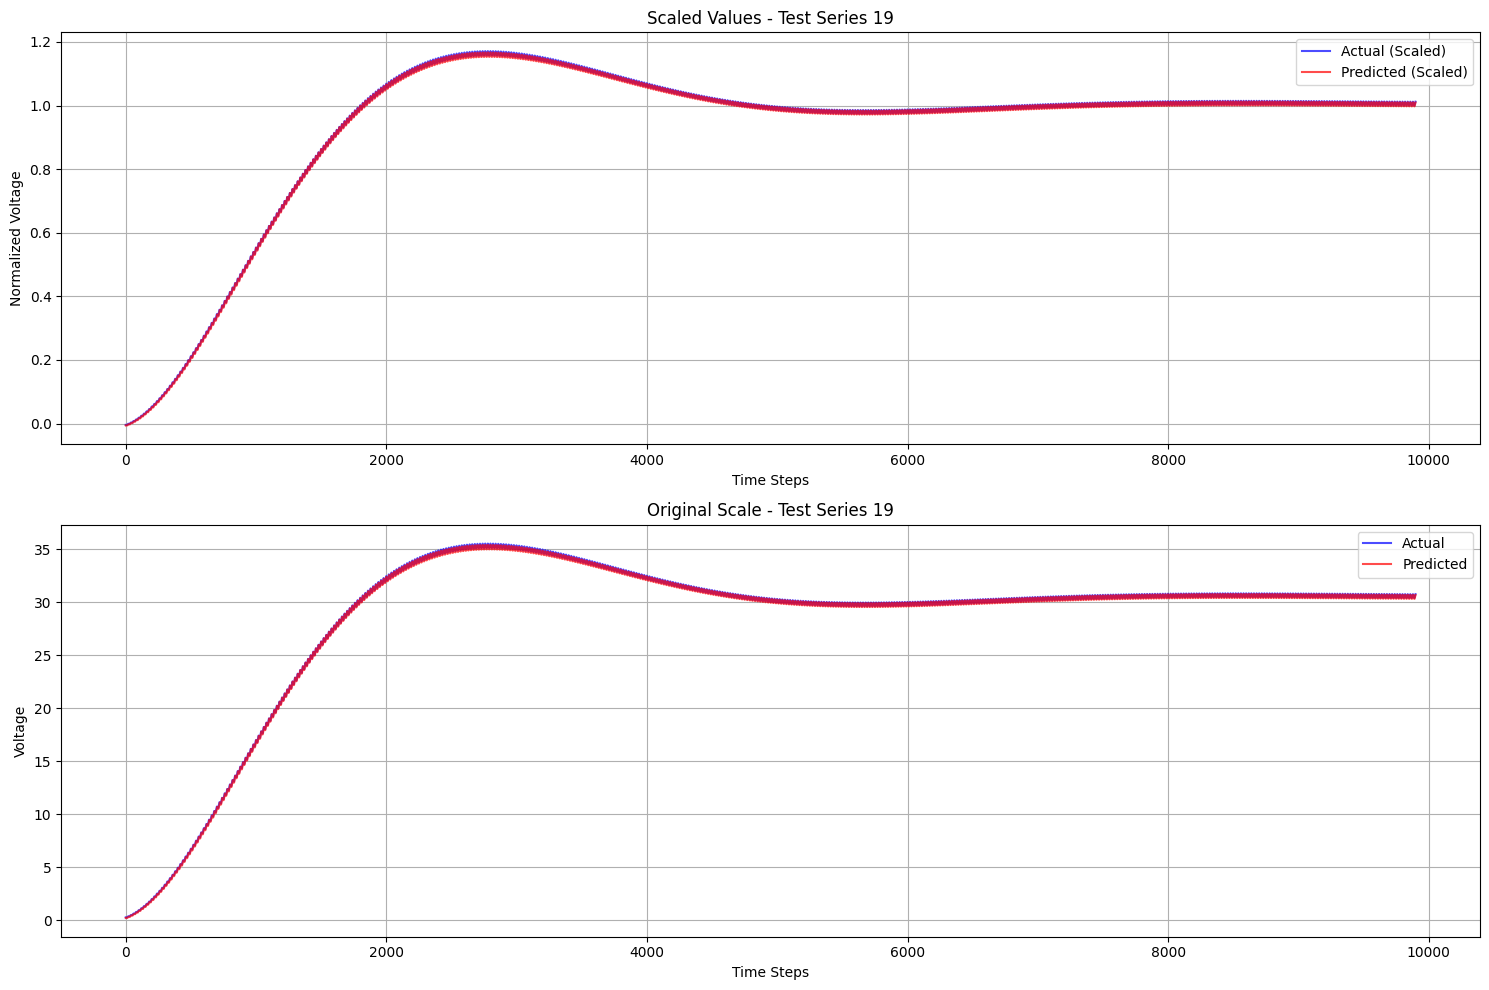

In [23]:
# Get a specific test series
test_series_id = test_series[0]
series_mask = (series_ids_test == test_series_id)

# Get the scaled predictions and actual values
scaled_actual = y_test_scaled[series_mask]
scaled_pred = y_pred_scaled[series_mask]

# Inverse transform to get original scale
original_actual = scaler_y.inverse_transform(scaled_actual.reshape(-1, 1)).flatten()
original_pred = scaler_y.inverse_transform(scaled_pred.reshape(-1, 1)).flatten()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot scaled values
ax1.plot(scaled_actual, label='Actual (Scaled)', color='blue', alpha=0.7)
ax1.plot(scaled_pred, label='Predicted (Scaled)', color='red', alpha=0.7)
ax1.set_title(f'Scaled Values - Test Series {test_series_id}')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Normalized Voltage')
ax1.grid(True)
ax1.legend()

# Plot original values
ax2.plot(original_actual, label='Actual', color='blue', alpha=0.7)
ax2.plot(original_pred, label='Predicted', color='red', alpha=0.7)
ax2.set_title(f'Original Scale - Test Series {test_series_id}')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Voltage')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Print some statistics
print("Scaled Values Range:")
print(f"Actual: [{scaled_actual.min():.3f}, {scaled_actual.max():.3f}]")
print(f"Predicted: [{scaled_pred.min():.3f}, {scaled_pred.max():.3f}]")
print("\nOriginal Values Range:")
print(f"Actual: [{original_actual.min():.3f}, {original_actual.max():.3f}]")
print(f"Predicted: [{original_pred.min():.3f}, {original_pred.max():.3f}]")

plt.show()

In [24]:
# Create a DataFrame with original actual and predicted values
comparison_df = pd.DataFrame({
    'Original_Actual': original_actual,
    'Original_Predicted': original_pred
})

# Calculate error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate various metrics
mae = mean_absolute_error(comparison_df['Original_Actual'], comparison_df['Original_Predicted'])
mse = mean_squared_error(comparison_df['Original_Actual'], comparison_df['Original_Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(comparison_df['Original_Actual'], comparison_df['Original_Predicted'])

# Add absolute error column to dataframe
comparison_df['Absolute_Error'] = abs(comparison_df['Original_Actual'] - comparison_df['Original_Predicted'])

# Print metrics
print("\nError Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Display first few rows of the comparison dataframe with errors
print("\nComparison DataFrame with Errors:")
print(comparison_df.head())

# Basic statistics of the absolute errors
print("\nAbsolute Error Statistics:")
print(comparison_df['Absolute_Error'].describe())


Error Metrics:
Mean Absolute Error (MAE): 0.0924
Mean Squared Error (MSE): 0.0107
Root Mean Squared Error (RMSE): 0.1032
R² Score: 0.9998

Comparison DataFrame with Errors:
   Original_Actual  Original_Predicted  Absolute_Error
0         0.259375            0.206836        0.052540
1         0.259056            0.214233        0.044822
2         0.258737            0.217885        0.040852
3         0.258418            0.218220        0.040199
4         0.258100            0.216099        0.042002

Absolute Error Statistics:
count    9900.000000
mean        0.092438
std         0.045931
min         0.000006
25%         0.068532
50%         0.099708
75%         0.123986
max         0.196823
Name: Absolute_Error, dtype: float64


In [26]:
comparison_df[1000:1200]

,Original_Actual,Original_Predicted,Absolute_Error
1000,16.996020,16.969772,0.026248
1001,16.977112,16.997581,0.020470
1002,16.958224,16.992544,0.034320
1003,16.939358,16.960209,0.020850
1004,16.920514,16.910221,0.010293
...,...,...,...
1195,20.736925,20.599909,0.137016
1196,20.807811,20.697647,0.110164
1197,20.878579,20.789839,0.088740
1198,20.949228,20.871017,0.078211



Test Series 19 - Original Values Range:
Actual: [0.256, 35.561]
Predicted: [0.201, 35.437]

Test Series 20 - Original Values Range:
Actual: [0.230, 37.023]
Predicted: [0.198, 36.915]

Test Series 21 - Original Values Range:
Actual: [0.325, 51.274]
Predicted: [0.243, 50.689]

Test Series 22 - Original Values Range:
Actual: [0.247, 52.851]
Predicted: [0.174, 52.182]

Test Series 23 - Original Values Range:
Actual: [0.303, 48.871]
Predicted: [0.293, 48.346]


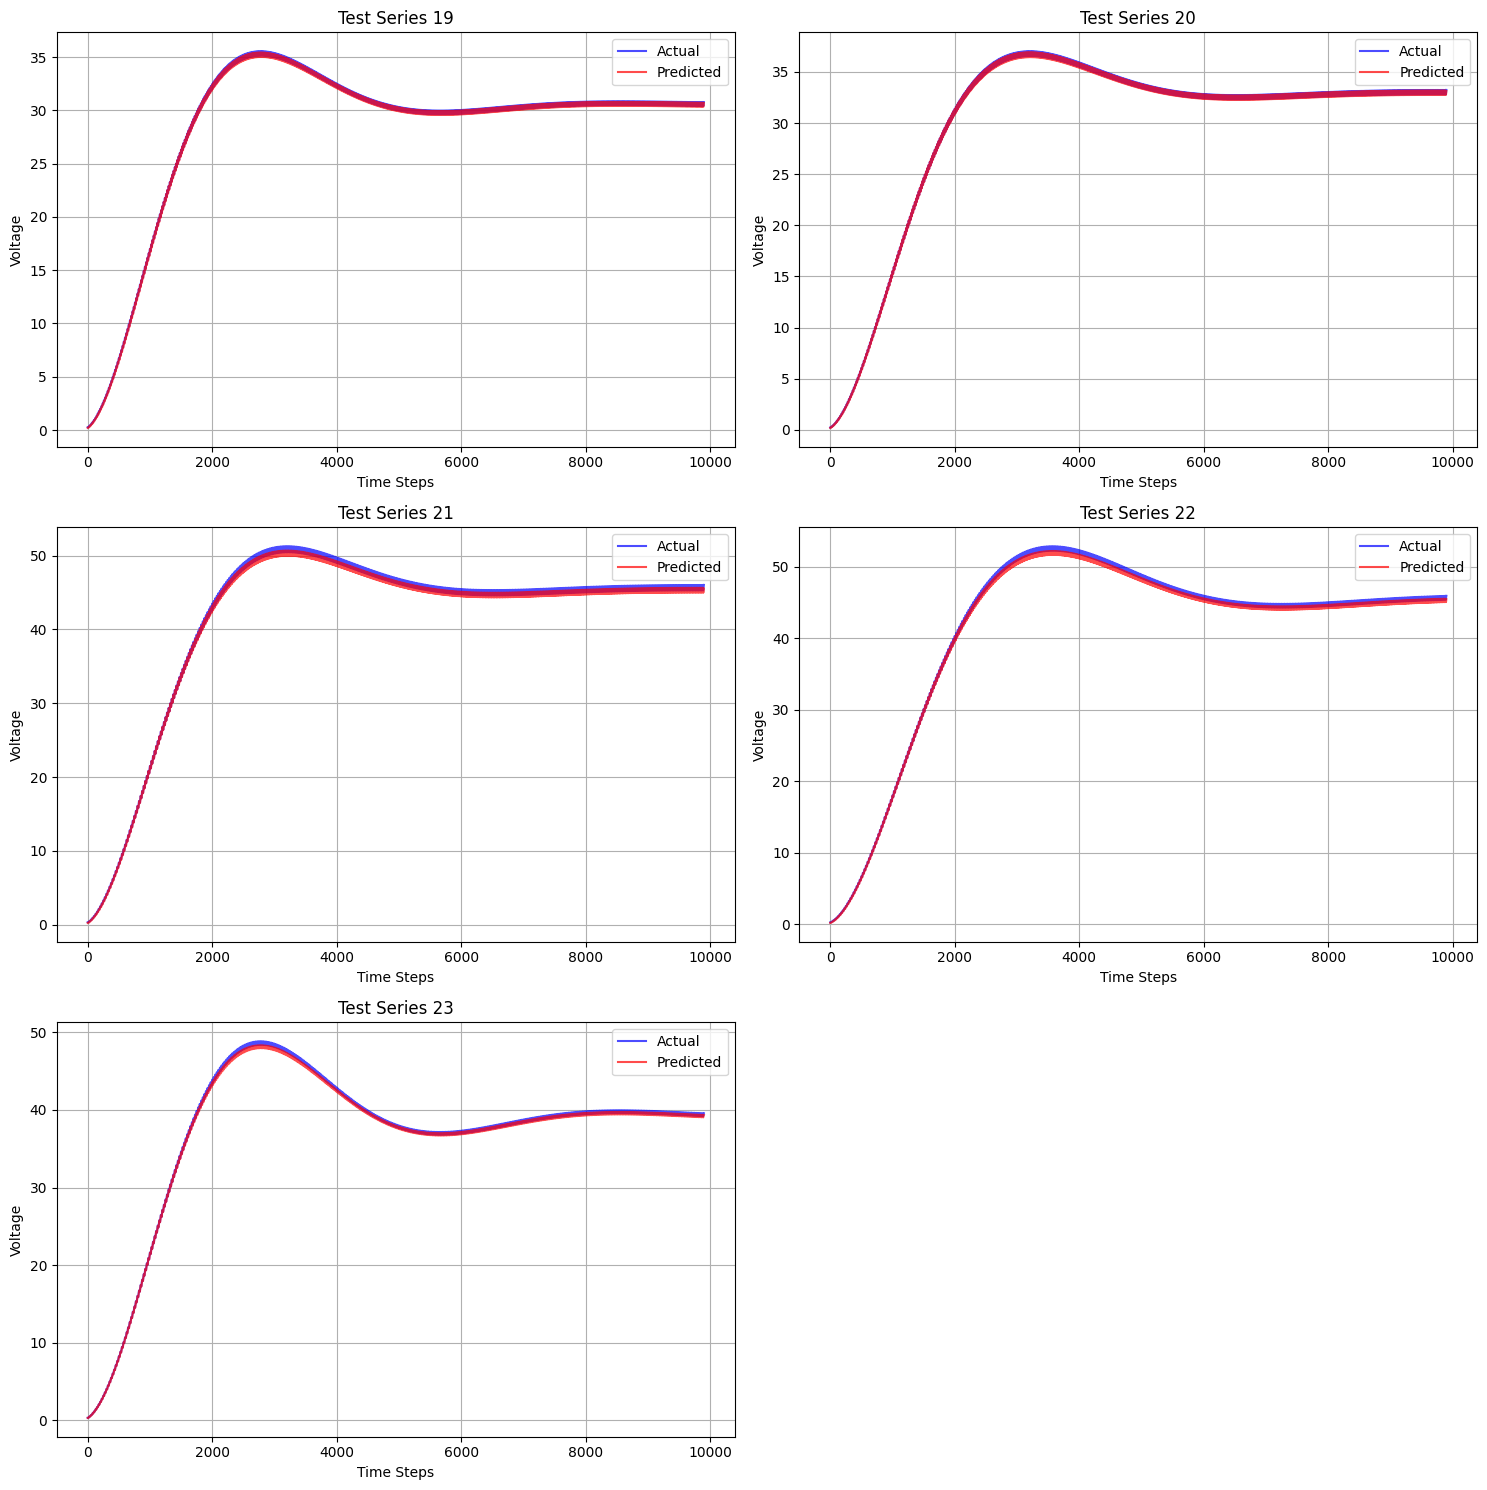

In [27]:
# Calculate number of rows needed for subplots
n_test_series = len(test_series)
n_rows = (n_test_series + 1) // 2  # 2 plots per row, rounded up
n_cols = 2

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten axes array for easier indexing

# Plot each test series
for idx, series_id in enumerate(test_series):
    # Get mask for this series
    series_mask = (series_ids_test == series_id)

    # Get scaled values
    scaled_actual = y_test_scaled[series_mask]
    scaled_pred = y_pred_scaled[series_mask]

    # Inverse transform to get original scale
    original_actual = scaler_y.inverse_transform(scaled_actual.reshape(-1, 1)).flatten()
    original_pred = scaler_y.inverse_transform(scaled_pred.reshape(-1, 1)).flatten()

    # Plot original values
    axes[idx].plot(original_actual, label='Actual', color='blue', alpha=0.7)
    axes[idx].plot(original_pred, label='Predicted', color='red', alpha=0.7)
    axes[idx].set_title(f'Test Series {series_id}')
    axes[idx].set_xlabel('Time Steps')
    axes[idx].set_ylabel('Voltage')
    axes[idx].grid(True)
    axes[idx].legend()

    # Print statistics for each series
    print(f"\nTest Series {series_id} - Original Values Range:")
    print(f"Actual: [{original_actual.min():.3f}, {original_actual.max():.3f}]")
    print(f"Predicted: [{original_pred.min():.3f}, {original_pred.max():.3f}]")

# Remove any empty subplots
for idx in range(n_test_series, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()